# General Data Analysis

## Data prep

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('/content/50k_50k.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df = df.dropna()

In [ ]:
df.head()

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3728460,172.31.66.35-52.165.231.192-49674-443-6,172.31.66.35,49674,52.165.231.192,443,6,20/02/2018 09:43:33,77544,2,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,5909663,172.31.0.2-172.31.69.6-53-59287-17,172.31.69.6,59287,172.31.0.2,53,17,20/02/2018 01:58:31,128898,2,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,1969542,172.31.64.107-104.20.117.11-53068-443-6,104.20.117.11,443,172.31.64.107,53068,6,20/02/2018 03:59:04,18,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,7886475,172.31.0.2-172.31.67.95-53-52695-17,172.31.67.95,52695,172.31.0.2,53,17,20/02/2018 12:50:44,72000,1,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,1693667,172.31.67.41-111.221.29.254-50498-443-6,111.221.29.254,443,172.31.67.41,50498,6,20/02/2018 11:45:13,52,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [ ]:
df.columns

Index(['Unnamed: 0', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port',
       'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag

In [ ]:
np.percentile(df["Flow Duration"], 99), df["Flow Duration"].max()

(np.float64(117595298.29), 119999930)

## Cleaning

### Timestamp

In [ ]:
from datetime import datetime

def parse_mixed_timestamp(ts):
    ts = ts.strip()  # Remove leading/trailing whitespace
    # Try 12-hour format first (with AM/PM)
    try:
        return datetime.strptime(ts, '%d/%m/%Y %I:%M:%S %p')
    except ValueError:
        pass

    # If that fails, try 24-hour format
    try:
        return datetime.strptime(ts, '%d/%m/%Y %H:%M:%S')
    except ValueError:
        # If all fails, return None or pd.NaT
        return pd.NaT


# Apply the custom parser row by row
df['Timestamp'] = df['Timestamp'].apply(parse_mixed_timestamp)

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


# Create separate columns for date and time
df['date'] = df['Timestamp'].dt.date    # This will be a date object (YYYY-MM-DD)
df['time'] = df['Timestamp'].dt.time    # This will be a time object (HH:MM:SS)

# Research Question

Volume over Time

- How many requests (or records) occur per minute, hour, or day? Do you see spikes at certain hours?

Peak Periods

- Are there specific times of day (e.g., 9 AM vs. 3 PM) when traffic is consistently heavier?

- Is the traffic peaking in intervals that might correlate with known events?


Distribution

- How is the traffic distributed across different days of the week (weekdays vs. weekends)?

- Is there a difference between normal business hours and off-business hours?

Attack Duration and Frequency

- Once a DDoS event starts, how long does it typically last?

- Do the attacks happen in quick succession or are they spread out?

Correlation with Other Factors

- Does the time of attack correlate with any other feature in the dataset?

- For example, if there is a “source IP” column, do certain IPs always show up at specific times?



# General Analysis

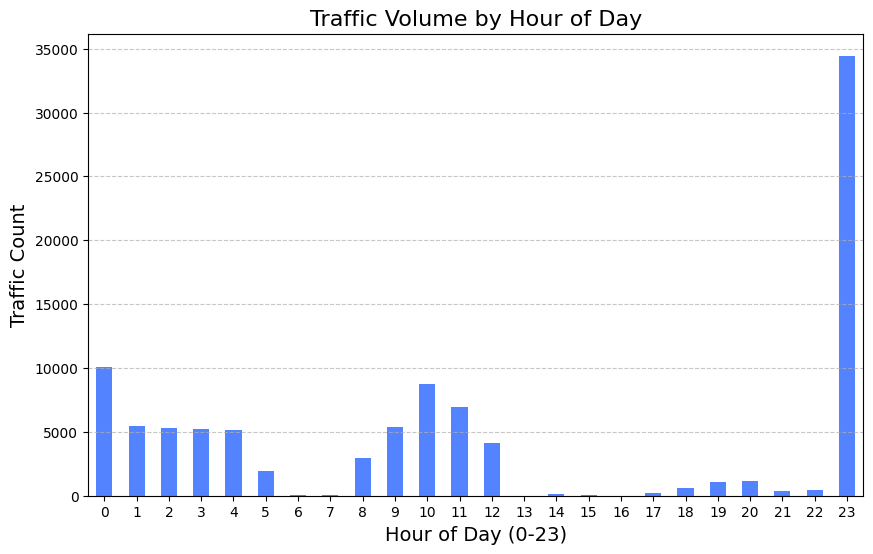

In [ ]:
# 1. Create an hour column
df['hour'] = df['Timestamp'].dt.hour

# 2. Count records by hour
hourly_counts = df.groupby('hour').size()
hourly_counts.rename("traffic_count", inplace=True)

# 3. Plot
plt.figure(figsize=(10,6))
hourly_counts.plot(kind='bar', color='#5383ff')

plt.title('Traffic Volume by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=14)
plt.ylabel('Traffic Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

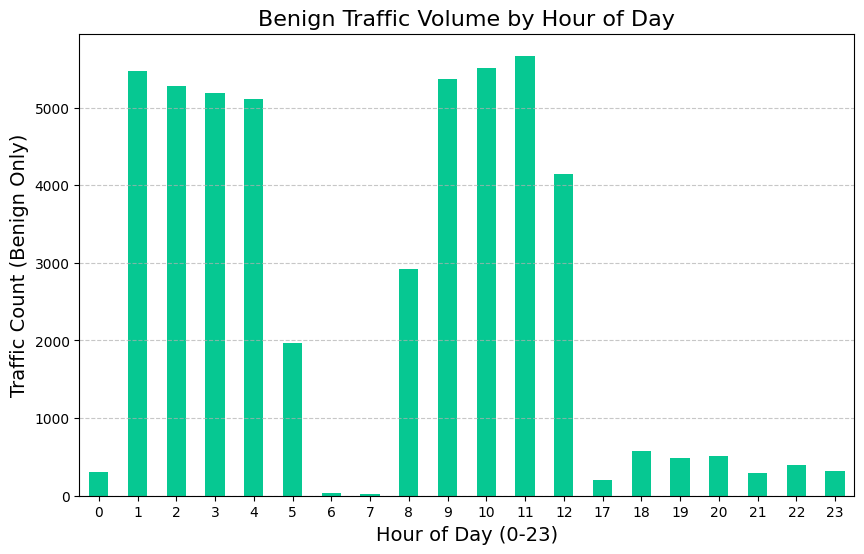

In [ ]:
# 1. Filter DataFrame to only benign rows
df_benign = df[df['Label'] == 'Benign'].copy()

# 2. Create an hour column (if not already present)
df_benign['hour'] = df_benign['Timestamp'].dt.hour

# 3. Count records by hour (total benign requests in that hour)
hourly_counts_benign = df_benign.groupby('hour').size()
hourly_counts_benign.rename("traffic_count", inplace=True)

# 4. Plot the bar chart
plt.figure(figsize=(10,6))
hourly_counts_benign.plot(kind='bar', color='#06c892')

plt.title('Benign Traffic Volume by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=14)
plt.ylabel('Traffic Count (Benign Only)', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

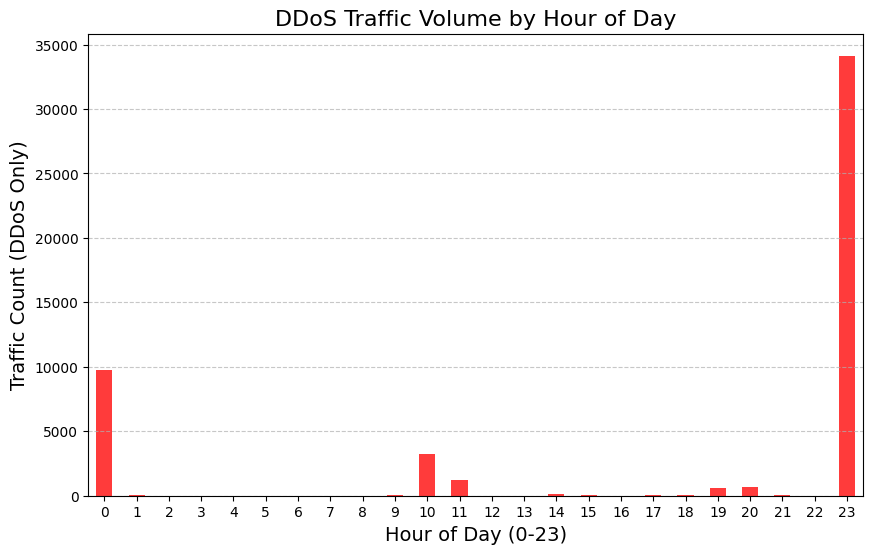

In [ ]:
import matplotlib.pyplot as plt

# 1. Filter DataFrame to only DDoS rows
df_ddos = df[df['Label'] == 'ddos'].copy()  # or 'DDoS' if that's the exact label

# 2. Create an hour column (if not already present)
df_ddos['hour'] = df_ddos['Timestamp'].dt.hour

# 3. Count records by hour (total DDoS requests in that hour)
hourly_counts_ddos = df_ddos.groupby('hour').size()
hourly_counts_ddos.rename("traffic_count", inplace=True)

# 4. Plot the bar chart
plt.figure(figsize=(10,6))
hourly_counts_ddos.plot(kind='bar', color='#ff3b3b')  # red color example

plt.title('DDoS Traffic Volume by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=14)
plt.ylabel('Traffic Count (DDoS Only)', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


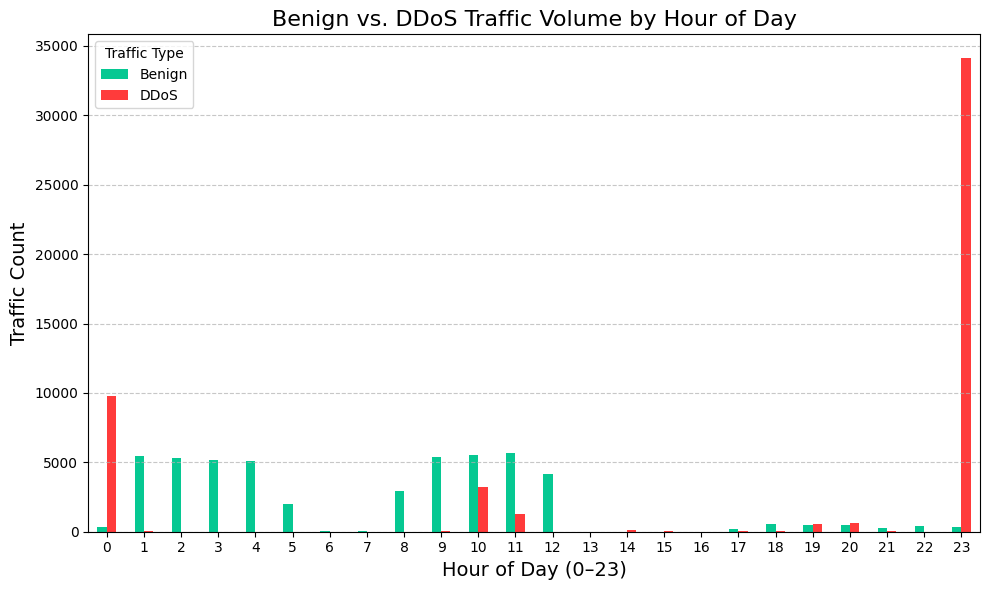

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Rename each Series so we have clear column names
benign_series = hourly_counts_benign.rename('Benign')
ddos_series   = hourly_counts_ddos.rename('DDoS')

# 2) Combine them into one DataFrame on the hour index
df_combined = pd.concat([benign_series, ddos_series], axis=1).fillna(0)

# 3) Plot a grouped bar chart
plt.figure(figsize=(10,6))
df_combined = df_combined.sort_index()
df_combined.plot(
    kind='bar',
    ax=plt.gca(),
    color=['#06c892', '#ff3b3b']
)

plt.title('Benign vs. DDoS Traffic Volume by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0–23)', fontsize=14)
plt.ylabel('Traffic Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Benign','DDoS'], title='Traffic Type')

plt.tight_layout()
plt.show()


### How many requests per minute occur in this hour on each day of the week?

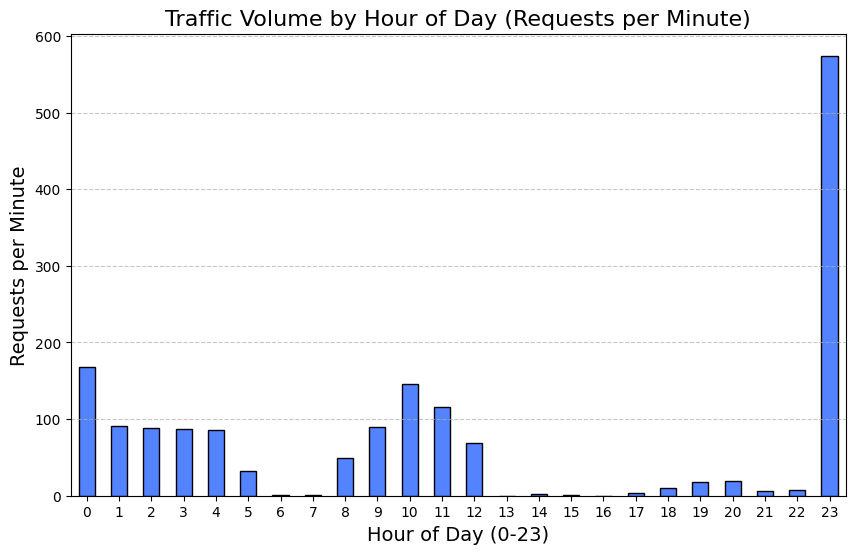

In [ ]:
# 2. Count records by hour (total requests in that hour)
hourly_counts = df.groupby('hour').size()
hourly_counts.rename("traffic_count", inplace=True)

# 3. Convert to "requests per minute" for each hour
#    Since each hour has 60 minutes, just divide by 60
hourly_counts_per_minute = hourly_counts / 60.0
hourly_counts_per_minute.rename("requests_per_minute", inplace=True)

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
hourly_counts_per_minute.plot(kind='bar', color='#5383ff', edgecolor='black')

plt.title('Traffic Volume by Hour of Day (Requests per Minute)', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=14)
plt.ylabel('Requests per Minute', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Overnight data size: 44495
Top 10 Source IPs (overnight):
Src IP
172.31.69.25      13658
18.219.193.20     13510
172.31.69.28       6952
18.216.24.42       1026
18.216.200.189      996
18.218.229.235      981
18.218.11.51        978
18.219.9.1          968
18.218.115.60       959
18.219.32.43        957
Name: count, dtype: int64


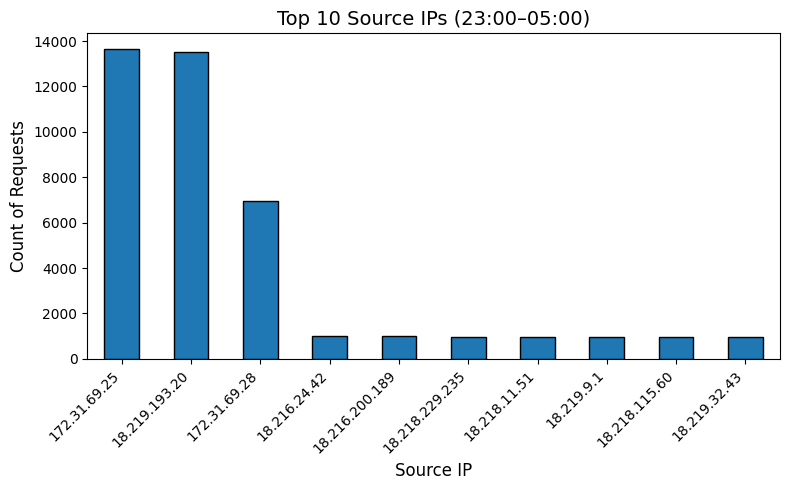

Top 10 (Src IP, Dst IP) pairs (overnight):
            Src IP         Dst IP  count
45    172.31.69.25  18.219.193.20  13658
63   18.219.193.20   172.31.69.25  13510
58    18.216.24.42   172.31.69.28   1026
57  18.216.200.189   172.31.69.28    996
61  18.218.229.235   172.31.69.28    981
59    18.218.11.51   172.31.69.28    978
66      18.219.9.1   172.31.69.28    968
60   18.218.115.60   172.31.69.28    959
64    18.219.32.43   172.31.69.28    957
65     18.219.5.43   172.31.69.28    951


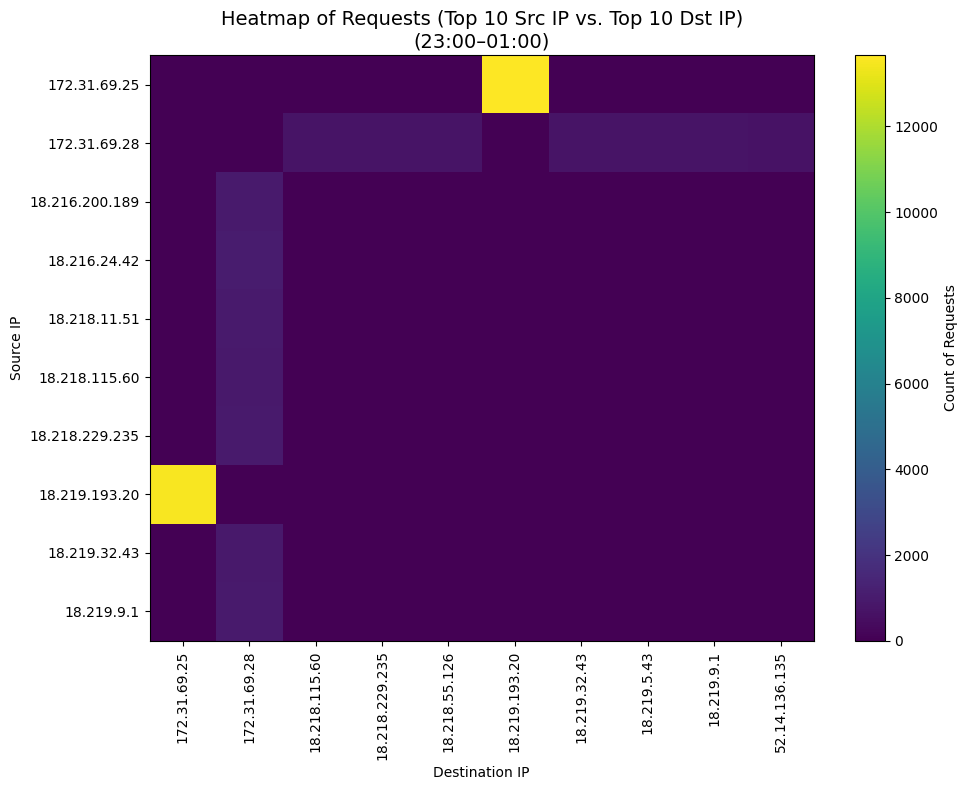

In [ ]:

mask = (df['hour'] >= 23) | (df['hour'] < 1)
overnight_df = df[mask].copy()

print("Overnight data size:", len(overnight_df))

# Count how many rows (requests) each Source IP has in the overnight window
src_counts = overnight_df['Src IP'].value_counts()
print("Top 10 Source IPs (overnight):")
print(src_counts.head(10))

# Plot the top 10 Source IPs
top_10_src = src_counts.head(10)

plt.figure(figsize=(8, 5))
top_10_src.plot(kind='bar', edgecolor='black')
plt.title('Top 10 Source IPs (23:00–05:00)', fontsize=14)
plt.xlabel('Source IP', fontsize=12)
plt.ylabel('Count of Requests', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check (Src IP, Dst IP) pairs
pair_counts = overnight_df.groupby(['Src IP', 'Dst IP']).size().reset_index(name='count')
pair_counts.sort_values('count', ascending=False, inplace=True)

print("Top 10 (Src IP, Dst IP) pairs (overnight):")
print(pair_counts.head(10))

# Visualize as a Heatmap for the top 20 source IPs and top 20 destination IPs

# Identify the top 20 source IPs overall
top_20_src = (
    pair_counts.groupby('Src IP')['count']
    .sum()
    .nlargest(20)
)

# Identify the top 10 destination IPs overall
top_10_dst = (
    pair_counts.groupby('Dst IP')['count']
    .sum()
    .nlargest(10)
)

# Filter pair_counts to only those top 20 in both categories
filtered_pairs = pair_counts[
    (pair_counts['Src IP'].isin(top_10_src.index)) &
    (pair_counts['Dst IP'].isin(top_10_dst.index))
]

# Pivot to a matrix: rows = Src IP, cols = Dst IP, values = count
pivot_df = filtered_pairs.pivot(index='Src IP', columns='Dst IP', values='count').fillna(0)


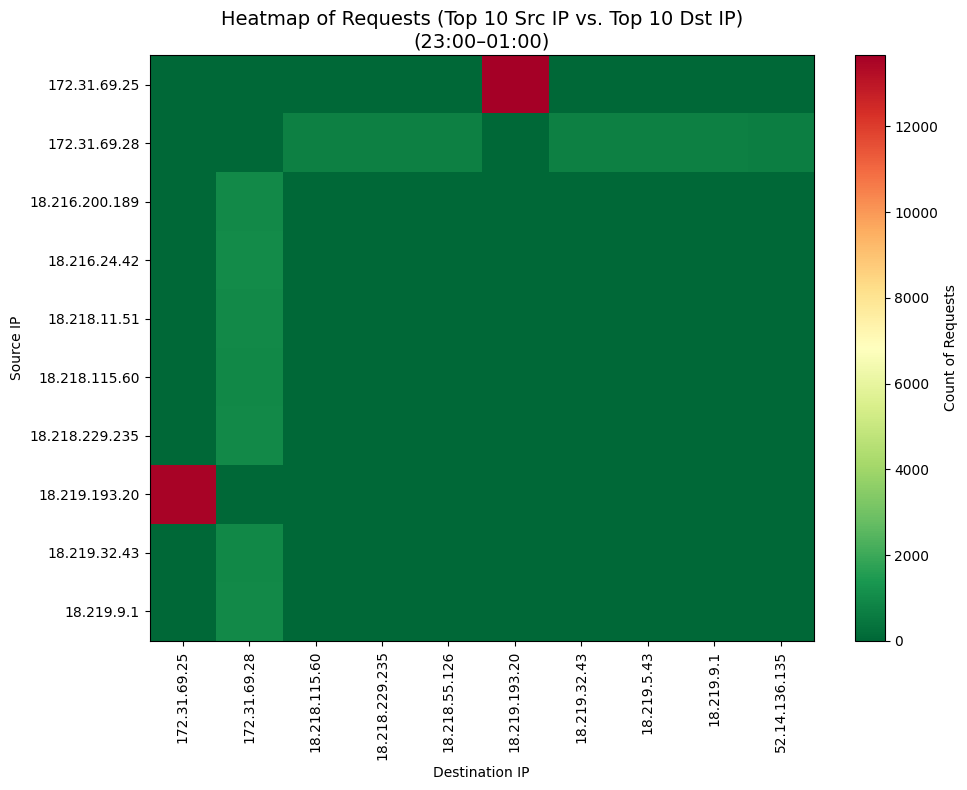

In [ ]:
import matplotlib.pyplot as plt

# 5e) Plot a heatmap with custom color scheme
plt.figure(figsize=(10, 8))
plt.imshow(pivot_df, aspect='auto', interpolation='nearest', cmap='RdYlGn_r')  # GREEN to RED

plt.title('Heatmap of Requests (Top 10 Src IP vs. Top 10 Dst IP)\n(23:00–01:00)', fontsize=14)
plt.xlabel('Destination IP')
plt.ylabel('Source IP')

# Tick labels
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns, rotation=90)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)

# Colorbar
plt.colorbar(label='Count of Requests')

plt.tight_layout()
plt.show()


In [ ]:
suspicious_src = "18.219.193.20"
suspicious_dst = "172.31.69.25"

# Filter your overnight_df (or main df) for that exact pair
suspicious_df = overnight_df[
    (overnight_df['Src IP'] == suspicious_src) &
    (overnight_df['Dst IP'] == suspicious_dst)
].copy()

print(suspicious_df['Label'].value_counts(dropna=False))

Label
ddos    13510
Name: count, dtype: int64


<ipython-input-65-d2eaaa190c19>:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  per_minute_fwd = forward_df.resample('T').size()
<ipython-input-65-d2eaaa190c19>:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  per_minute_bwd = reverse_df.resample('T').size()


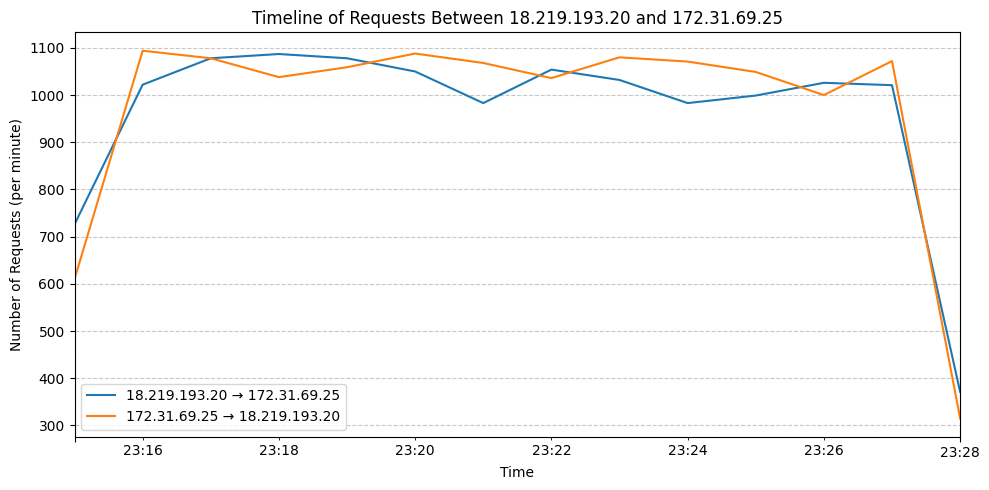

In [ ]:
# Forward traffic (src -> dst):
forward_df = overnight_df[
    (overnight_df['Src IP'] == suspicious_src) &
    (overnight_df['Dst IP'] == suspicious_dst)
].copy()

# Reverse traffic (dst -> src):
reverse_df = overnight_df[
    (overnight_df['Src IP'] == suspicious_dst) &
    (overnight_df['Dst IP'] == suspicious_src)
].copy()

# Prepare forward traffic
forward_df.set_index('Timestamp', inplace=True)
per_minute_fwd = forward_df.resample('T').size()

# Prepare reverse traffic
reverse_df.set_index('Timestamp', inplace=True)
per_minute_bwd = reverse_df.resample('T').size()

plt.figure(figsize=(10, 5))

# Plot forward direction
per_minute_fwd.plot(label=f'{suspicious_src} → {suspicious_dst}')

# Plot reverse direction
per_minute_bwd.plot(label=f'{suspicious_dst} → {suspicious_src}')

plt.title(f'Timeline of Requests Between {suspicious_src} and {suspicious_dst}')
plt.xlabel('Time')
plt.ylabel('Number of Requests (per minute)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()